In [1]:
from sim_util import load_tiff_sequence
import json

import skimage
import numpy as np
from scipy.spatial import KDTree
from scipy.optimize import linear_sum_assignment

def get_descriptor(spot, spots, neighbors_for_descriptor = 3):
    kd = KDTree(spots)
    ds, idxs = kd.query(spot, k=neighbors_for_descriptor+1)
    d_vecs = spot - spots[idxs[1:]]
    desc = d_vecs.flatten()
    return desc

def match_kd(descs_a, descs_b):
    kd = KDTree(descs_a)
    ds, idxes = kd.query(descs_b)
    return idxes


def match_la(descs_a, descs_b):
    
    descs_a = np.array(descs_a)
    descs_b = np.array(descs_b)
        
    n_spots_max = np.max([descs_a.shape[0], descs_b.shape[0]])
    n_spots_a = descs_a.shape[0]
    n_spots_b = descs_b.shape[0]
    
    # pad for empty assignment
    if (n_spots_b > n_spots_a):
        descs_a = np.concatenate((descs_a, descs_b[descs_a.shape[0]:]))
    if (n_spots_b < n_spots_a):
        descs_b = np.concatenate((descs_b, descs_a[descs_b.shape[0]:]))
    
    print (descs_a)
    print (descs_b)
    a = np.tile(descs_a, [n_spots_max, 1] )
    b = np.repeat(descs_b, n_spots_max, 0)
    ds = np.sqrt(np.sum((a-b)**2, axis=1)).reshape((n_spots_max, n_spots_max))

    _, idxes_la = linear_sum_assignment(ds)
    idxes_la[idxes_la>=n_spots_a] = -1
    return idxes_la[:n_spots_b]

/Users/david/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/david/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
desc_img = load_tiff_sequence('/Volumes/davidh-ssd/mv-sim/sim_tissue/sim-bbeam-x0-yall-zall-i2-l500/', 'bbeam_sim_c2.*')

In [ ]:
desc_img.shape

from skimage.feature import peak_local_max
import numpy as np
from scipy import ndimage as ndi

norm = desc_img / np.max(desc_img)

peaks = peak_local_max(ndi.gaussian_filter(desc_img, 1), threshold_rel=0.005, min_distance=7)
peaks = peaks * 4


descs = [get_descriptor(p, peaks, 4) for p in peaks]
peaks.shape

In [ ]:
import json
from functools import reduce
from operator import add
from argparse import Namespace

n = Namespace()

def_path = '/Volumes/davidh-ssd/mv-sim/sim_tissue/sim2.json'
with open(def_path, 'r') as fd:
    params = json.load(fd)
    
n.__dict__.update(params)
gt = reduce(add, [v['points'] for v in n.fields.values()])
np.array(gt).shape


descs_gt = [get_descriptor(p, np.array(gt), 4) for p in gt]
descs_gt

In [ ]:
idxes = match_la(descs, descs_gt)

for i_gt, i in enumerate(idxes):
    print(peaks[i], gt[i_gt])

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,10]


plt.imshow(np.max(ndi.gaussian_filter(desc_img,1), axis=0)**0.5)
#for g in gt:
for g in [peaks[i] for i in idxes]:
#for g in peaks:
    e = Ellipse((g[2]//4, g[1]//4), 10, 10, color='r', fill=None)
    plt.gca().add_artist(e)
plt.show()

In [3]:
from sim_util import load_tiff_sequence, save_as_sequence
import numpy as np
from itertools import product

signal_imgs = [load_tiff_sequence(
    '/Volumes/davidh-ssd/mv-sim/sim3/sim3-bbeam-x{}-yall-zall-i2-l500/'.format(i),
    'bbeam_sim_c1.*') for i in range(4)]

desc_imgs = [load_tiff_sequence(
    '/Volumes/davidh-ssd/mv-sim/sim3/sim3-bbeam-x{}-yall-zall-i2-l500/'.format(i),
    'bbeam_sim_c2.*') for i in range(4)]

In [27]:
import numpy as np
from numpy.random import poisson
from itertools import product
from sim_util import load_tiff_sequence, save_as_sequence

n_tiles_x = 4
n_tiles_y = 4
n_tiles_z = 1
two_sided_illum = True

q_signal = 0.98
q_descs = 1.0

snr_signal = 10
snr_descs = 20

in_fpath = '/Volumes/davidh-ssd/mv-sim/sim3/sim3-bbeam-x{x}-y{y}-z{z}-i{ill}-l500/'
out_fpath = '/Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x{x}-y{y}-z{z}-i{ill}-l500/'
add_poisson = True

signal_imgs = []
desc_imgs = []
for (x,y,z,ill) in product(range(n_tiles_x), range(n_tiles_y), range(n_tiles_z), [1] if not two_sided_illum else [1,2]):

    signal_img = load_tiff_sequence(in_fpath.format(x=x, y=y, z=z, ill=ill), 'bbeam_sim_c1.*')
    desc_img = load_tiff_sequence(in_fpath.format(x=x, y=y, z=z, ill=ill), 'bbeam_sim_c2.*')
    signal_imgs.append(signal_img)
    desc_imgs.append(desc_img)
    
    print('loaded tile x={} y={}, z={}, illum={}'.format(x,y,z,ill))
    
qs_signal = np.array([np.quantile(signal_img, q_signal) for signal_img in signal_imgs])
qs_desc = np.array([np.quantile(desc_img, q_descs) for desc_img in desc_imgs])
mq_signal = np.mean(qs_signal)
mq_desc = np.mean(qs_desc)

print('mean {}-quantile of signal images: {}'.format(q_signal, mq_signal))
print('mean {}-quantile of descriptor images: {}'.format(q_descs, mq_desc))

for (i,(x,y,z,ill)) in enumerate(product(range(n_tiles_x), range(n_tiles_y), range(n_tiles_z), [1] if not two_sided_illum else [1,2])):
    
    signal_img = signal_imgs[i]
    desc_img = desc_imgs[i]
    
    signal_img /= mq_signal
    desc_img /= mq_desc
    signal_img *= snr_signal**2
    desc_img *= snr_descs**2
    
    if add_poisson:
        signal_img = poisson(signal_img)
        desc_img = poisson(desc_img)
        
    out_dir = out_fpath.format(x=x, y=y, z=z, ill=ill)
    
    save_as_sequence(signal_img, out_dir, 'bbeam_sim_c1_z{plane}.tif')
    save_as_sequence(desc_img, out_dir, 'bbeam_sim_c2_z{plane}.tif')
    
    print('saved intensity adjusted tile x={} y={}, z={}, illum={}'.format(x,y,z,ill))
    


loaded tile x=0 y=0, z=0, illum=1
loaded tile x=0 y=0, z=0, illum=2
loaded tile x=0 y=1, z=0, illum=1
loaded tile x=0 y=1, z=0, illum=2
loaded tile x=0 y=2, z=0, illum=1
loaded tile x=0 y=2, z=0, illum=2
loaded tile x=0 y=3, z=0, illum=1
loaded tile x=0 y=3, z=0, illum=2
loaded tile x=1 y=0, z=0, illum=1
loaded tile x=1 y=0, z=0, illum=2
loaded tile x=1 y=1, z=0, illum=1
loaded tile x=1 y=1, z=0, illum=2
loaded tile x=1 y=2, z=0, illum=1
loaded tile x=1 y=2, z=0, illum=2
loaded tile x=1 y=3, z=0, illum=1
loaded tile x=1 y=3, z=0, illum=2
loaded tile x=2 y=0, z=0, illum=1
loaded tile x=2 y=0, z=0, illum=2
loaded tile x=2 y=1, z=0, illum=1
loaded tile x=2 y=1, z=0, illum=2
loaded tile x=2 y=2, z=0, illum=1
loaded tile x=2 y=2, z=0, illum=2
loaded tile x=2 y=3, z=0, illum=1
loaded tile x=2 y=3, z=0, illum=2
loaded tile x=3 y=0, z=0, illum=1
loaded tile x=3 y=0, z=0, illum=2
loaded tile x=3 y=1, z=0, illum=1
loaded tile x=3 y=1, z=0, illum=2
loaded tile x=3 y=2, z=0, illum=1
loaded tile x=

/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i1-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i1-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i1-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i1-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=0 y=0, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i2-l500/bbeam_sim_c2_z93.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i2-l500/bbeam_sim_c2_z94.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i2-l500/bbeam_sim_c2_z95.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y0-z0-i2-l500/bbeam_sim_c2_z96.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=0 y=0, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y1-z0-i1-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y1-z0-i1-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y1-z0-i1-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y1-z0-i1-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=0 y=1, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y1-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y1-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y1-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y1-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=0 y=1, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y2-z0-i1-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y2-z0-i1-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y2-z0-i1-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y2-z0-i1-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=0 y=2, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y2-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y2-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y2-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y2-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=0 y=2, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y3-z0-i1-l500/bbeam_sim_c2_z81.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


saved intensity adjusted tile x=0 y=3, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y3-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y3-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y3-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x0-y3-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=0 y=3, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y0-z0-i1-l500/bbeam_sim_c2_z78.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y0-z0-i1-l500/bbeam_sim_c2_z79.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y0-z0-i1-l500/bbeam_sim_c2_z83.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y0-z0-i1-l500/bbeam_sim_c2_z84.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=1 y=0, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y0-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y0-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y0-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y0-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=1 y=0, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y1-z0-i1-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y1-z0-i1-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y1-z0-i1-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y1-z0-i1-l500/bbeam_sim_c2_z37.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=1 y=1, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y1-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y1-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y1-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y1-z0-i2-l500/bbeam_sim_c2_z38.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=1 y=1, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y2-z0-i1-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y2-z0-i1-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y2-z0-i1-l500/bbeam_sim_c2_z58.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y2-z0-i1-l500/bbeam_sim_c2_z59.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=1 y=2, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y2-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y2-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y2-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y2-z0-i2-l500/bbeam_sim_c2_z49.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=1 y=2, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y3-z0-i1-l500/bbeam_sim_c2_z40.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y3-z0-i1-l500/bbeam_sim_c2_z41.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y3-z0-i1-l500/bbeam_sim_c2_z42.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y3-z0-i1-l500/bbeam_sim_c2_z43.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=1 y=3, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y3-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y3-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y3-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x1-y3-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=1 y=3, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y0-z0-i1-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y0-z0-i1-l500/bbeam_sim_c2_z80.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y0-z0-i1-l500/bbeam_sim_c2_z81.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y0-z0-i1-l500/bbeam_sim_c2_z82.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=2 y=0, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y0-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y0-z0-i2-l500/bbeam_sim_c2_z21.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y0-z0-i2-l500/bbeam_sim_c2_z39.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y0-z0-i2-l500/bbeam_sim_c2_z40.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=2 y=0, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y1-z0-i1-l500/bbeam_sim_c2_z54.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y1-z0-i1-l500/bbeam_sim_c2_z55.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y1-z0-i1-l500/bbeam_sim_c2_z56.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y1-z0-i1-l500/bbeam_sim_c2_z57.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=2 y=1, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y1-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y1-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y1-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y1-z0-i2-l500/bbeam_sim_c2_z04.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=2 y=1, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y2-z0-i1-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y2-z0-i1-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y2-z0-i1-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y2-z0-i1-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=2 y=2, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y2-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y2-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y2-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y2-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=2 y=2, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y3-z0-i1-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y3-z0-i1-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y3-z0-i1-l500/bbeam_sim_c2_z86.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y3-z0-i1-l500/bbeam_sim_c2_z87.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=2 y=3, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y3-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y3-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y3-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x2-y3-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=2 y=3, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y0-z0-i1-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y0-z0-i1-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y0-z0-i1-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y0-z0-i1-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=3 y=0, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y0-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y0-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y0-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y0-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=3 y=0, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y1-z0-i1-l500/bbeam_sim_c2_z72.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y1-z0-i1-l500/bbeam_sim_c2_z73.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y1-z0-i1-l500/bbeam_sim_c2_z74.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y1-z0-i1-l500/bbeam_sim_c2_z78.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=3 y=1, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y1-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y1-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y1-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y1-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=3 y=1, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y2-z0-i1-l500/bbeam_sim_c2_z66.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y2-z0-i1-l500/bbeam_sim_c2_z67.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y2-z0-i1-l500/bbeam_sim_c2_z68.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y2-z0-i1-l500/bbeam_sim_c2_z69.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=3 y=2, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y2-z0-i2-l500/bbeam_sim_c2_z66.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y2-z0-i2-l500/bbeam_sim_c2_z67.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y2-z0-i2-l500/bbeam_sim_c2_z68.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y2-z0-i2-l500/bbeam_sim_c2_z69.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=3 y=2, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i1-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i1-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i1-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i1-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=3 y=3, z=0, illum=1


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i2-l500/bbeam_sim_c2_z00.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i2-l500/bbeam_sim_c2_z01.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i2-l500/bbeam_sim_c2_z02.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i2-l500/bbeam_sim_c2_z03.tif is a low contrast image
  warn('%s is a low contr

saved intensity adjusted tile x=3 y=3, z=0, illum=2


/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i2-l500/bbeam_sim_c2_z84.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i2-l500/bbeam_sim_c2_z85.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i2-l500/bbeam_sim_c2_z86.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/david/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /Volumes/davidh-ssd/mv-sim/sim3/intensity_adjusted/sim3-bbeam-x3-y3-z0-i2-l500/bbeam_sim_c2_z87.tif is a low contrast image
  warn('%s is a low contr

array([[[  0,   0,   4, ...,  45,  38,  49],
        [  0,   3,   0, ...,  40,  29,  18],
        [  0,   8,  11, ...,  25,  42,  41],
        ...,
        [  0,  15,   6, ...,  62,  47,  51],
        [  1,   4,   0, ...,  45,  49,  49],
        [  2,   2,   3, ...,  43,  43,  43]],

       [[  8,   5,   3, ...,  41,  21,  31],
        [ 11,   8,   6, ...,  65,  36,  22],
        [  5,   9,   0, ...,  42,  36,  41],
        ...,
        [  0,   3,   2, ...,  47,  51,  59],
        [  0,   0,   3, ...,  57,  39,  47],
        [  0,  10,   0, ...,  49,  28,  36]],

       [[  5,   3,  11, ...,  54,  43,  11],
        [  0,   2,  12, ...,  68,  39,  18],
        [  5,  21,   2, ...,  36,  31,  31],
        ...,
        [  0,  20,   7, ...,  54,  56,  29],
        [  4,   3,   0, ...,  28,  35,  41],
        [  7,   5,   0, ...,  33,  51,  42]],

       ...,

       [[117, 149, 127, ...,  36,  22,  45],
        [104,  99, 139, ...,  48,  31,  32],
        [ 79, 132, 151, ...,  60,  25,  26

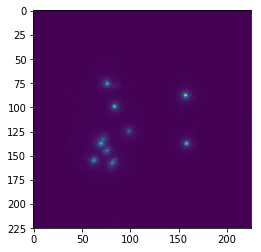

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

ps = poisson(signal_img / np.quantile(signal_img, q_signal) * snr_signal**2)

plt.imshow(np.max(desc_img, axis=0))
ps

In [9]:
for i in range(len(signal_imgs)):
    print(np.quantile(signal_imgs[i], [0.1, 0.5, 0.9]))
    
print('descs')

for i in range(len(desc_imgs)):
    print(np.quantile(desc_imgs[i], [0.1, 0.5, 0.9, 1.0]))

[1.06000650e-05 4.43538156e-04 1.34130828e-02]
[1.02057047e-05 4.25449762e-04 1.28289964e-02]
[9.85372208e-06 4.08139022e-04 1.23097192e-02]
[9.55626729e-06 3.93296956e-04 1.18560065e-02]
descs


ValueError: Quantiles must be in the range [0, 1]

In [6]:
combd = np.stack(signal_imgs)
combd_desc = np.stack(desc_imgs)
print(np.quantile(combd, [0.1, 0.5, 0.9]))
print(np.quantile(combd_desc, [0.99, 0.999, 0.9999, 0.99999]))
combd.shape

[1.00420803e-05 4.17224292e-04 1.26134111e-02]
[1.10499999e-07 2.55928580e-06 1.26658293e-05 3.41457848e-05]


(4, 128, 1024, 1024)

In [ ]:
plt.imshow(np.max(desc_imgs[0]/3.41457848e-05, axis=0))
np.max(desc_imgs[0]/3.41457848e-05)

peak_local_max(desc_imgs[0], threshold_rel=0.5)

In [ ]:
plt.rcParams['figure.figsize'] = [15,15]

from calmutils.localization import detect_dog

peaks = detect_dog(desc_imgs[0], 0.002, 2.0)
#peaks = peak_local_max(ndi.gaussian_laplace(desc_imgs[0], 3), threshold_rel=0.05)
plt.imshow(np.max(desc_imgs[0], axis=0)**0.35)

for g in peaks:
    e = Ellipse((g[2], g[1]), 10, 10, color='r', fill=None)
    plt.gca().add_artist(e)
plt.show()

len(peaks)

In [ ]:
peaks

n = Namespace()

def_path = '/Volumes/davidh-ssd/mv-sim/sim3/sim3.json'
with open(def_path, 'r') as fd:
    params = json.load(fd)
    
n.__dict__.update(params)
gt = reduce(add, [v['points'] for v in n.fields.values()])

gt_1 = list(n.fields.values())[7]['points']

get_desc = [get_descriptor(g, np.array(gt_1), 9) for g in gt_1]

desc = [get_descriptor(p*2, np.array(peaks)*2, 9) for p in peaks]

idxes = match_kd(desc, get_desc)

plt.imshow(np.max(desc_imgs[0], axis=0)**0.35)

for i_gt, i in enumerate(idxes):
    g=peaks[i]
    print(peaks[i]*2, gt_1[i_gt])
    e = Ellipse((g[2], g[1]), 10, 10, color='r', fill=None)
    plt.gca().add_artist(e)
plt.show()

p1=[peaks[i]*2 for i in idxes]

from skimage.transform import AffineTransform
from skimage.measure import ransac

# FAIL: only 2d in skimage -> ImgLib2
np.array(gt_1).shape, np.array(p1).shape
ransac((np.array(gt_1), np.array(p1)), AffineTransform, 4, 5)


In [31]:
import json

with open('/Volumes/davidh-ssd/mv-sim/sim3/sim3.json', 'r') as fd:
    params = json.load(fd)
    
params['fields']

{'1,2,0': {'points': [[82, 1279, 773],
   [100, 1155, 908],
   [138, 1321, 761],
   [66, 1265, 857],
   [109, 1243, 742],
   [80, 1317, 914],
   [87, 1261, 872],
   [68, 1222, 748],
   [56, 1185, 923],
   [95, 1222, 899]],
  'off': [5, -4, -10]},
 '0,3,0': {'points': [[83, 1554, 391],
   [99, 1586, 484],
   [119, 1548, 409],
   [59, 1632, 397],
   [129, 1652, 503],
   [78, 1557, 435],
   [186, 1574, 347],
   [200, 1601, 501],
   [153, 1551, 515],
   [74, 1715, 433]],
  'off': [1, 6, 3]},
 '2,0,0': {'points': [[62, 443, 1203],
   [148, 511, 1301],
   [195, 486, 1292],
   [110, 381, 1195],
   [85, 433, 1263],
   [187, 407, 1254],
   [56, 425, 1166],
   [114, 439, 1249],
   [146, 330, 1184],
   [113, 494, 1265]],
  'off': [0, 1, 3]},
 '3,0,0': {'points': [[158, 475, 1686],
   [196, 439, 1552],
   [93, 488, 1646],
   [174, 382, 1658],
   [60, 454, 1582],
   [160, 344, 1599],
   [62, 479, 1682],
   [169, 334, 1528],
   [145, 381, 1576],
   [179, 471, 1693]],
  'off': [-9, 2, 8]},
 '0,1,0': 